# Creation of a custom distribution or copula

In this example we are going to create a distribution or copula.

The way to go is inheriting the PythonDistribution class and overload the methods of the Distribution object.

To create a Copula, the user has to overload isCopula() and return True.

Then an instance of the new class can be passed on into a Distribution object.

At least computeCDF should be overriden.

In [6]:
from __future__ import print_function
import openturns as ot
import math as m

In [7]:
# Inherit PythonDistribution
class UniformNdPy(ot.PythonDistribution):

    def __init__(self, a=[0.0], b=[1.0]):
        super(UniformNdPy, self).__init__(len(a))
        if len(a) != len(b):
            raise ValueError('Invalid bounds')
        for i in range(len(a)):
            if a[i] > b[i]:
                raise ValueError('Invalid bounds')
        self.a = a
        self.b = b
        self.factor = 1.0
        for i in range(len(a)):
            self.factor *= (b[i] - a[i])

    def getRange(self):
        return ot.Interval(self.a, self.b, [True] * len(self.a), [True] * len(self.a))

    def getRealization(self):
        X = []
        for i in range(len(self.a)):
            X.append(
                self.a[i] + (self.b[i] - self.a[i]) * ot.RandomGenerator.Generate())
        return X

    def getSample(self, size):
        X = []
        for i in range(size):
            X.append(self.getRealization())
        return X

    def computeCDF(self, X):
        prod = 1.0
        for i in range(len(self.a)):
            if X[i] < self.a[i]:
                return 0.0
            prod *= (min(self.b[i], X[i]) - self.a[i])
        return prod / self.factor

    def computePDF(self, X):
        for i in range(len(self.a)):
            if X[i] < self.a[i]:
                return 0.0
            if X[i] > self.b[i]:
                return 0.0
        return 1.0 / self.factor

    def getMean(self):
        mu = []
        for i in range(len(self.a)):
            mu.append(0.5 * (self.a[i] + self.b[i]))
        return mu

    def getStandardDeviation(self):
        stdev = []
        for i in range(len(self.a)):
            stdev.append((self.b[i] - self.a[i]) / m.sqrt(12.))
        return stdev

    def getSkewness(self):
        return [0.] * len(self.a)

    def getKurtosis(self):
        return [1.8] * len(self.a)

    def getStandardMoment(self, n):
        if n % 2 == 1:
            return [0.] * len(self.a)
        return [1. / (n + 1.)] * len(self.a)

    def getMoment(self, n):
        return [-0.1 * n] * len(self.a)

    def getCenteredMoment(self, n):
        return [0.] * len(self.a)

    def computeCharacteristicFunction(self, x):
        if len(self.a) > 1:
            raise ValueError('dim>1')
        ax = self.a[0] * x
        bx = self.b[0] * x
        return (m.sin(bx) - m.sin(ax) + 1j * (m.cos(ax) - m.cos(bx))) / (bx - ax)

    def isElliptical(self):
        return (len(self.a) == 1) and (self.a[0] == -self.b[0])

    def isCopula(self):
        for i in range(len(self.a)):
            if self.a[i] != 0.0:
                return False
            if self.b[i] != 1.0:
                return False
        return True

    def getMarginal(self, indices):
        subA = []
        subB = []
        for i in indices:
            subA.append(self.a[i])
            subB.append(self.b[i])
        py_dist = UniformNdPy(subA, subB)
        return ot.Distribution(py_dist)

    def computeQuantile(self, prob, tail=False):
        q = 1.0 - prob if tail else prob
        quantile = self.a
        for i in range(len(self.a)):
            quantile[i] += q * (self.b[i] - self.a[i])
        return quantile

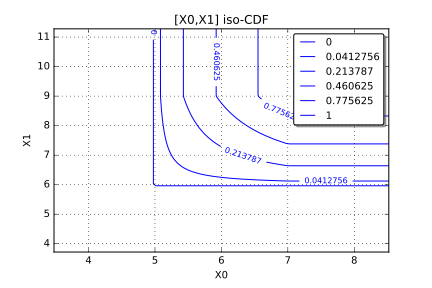

In [8]:
# Instanciate our distribution
distribution = ot.Distribution(UniformNdPy([5, 6], [7, 9]))
distribution.drawCDF()

In [9]:
# Get a sample
distribution.getSample(5)

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=2 data=[[6.25975,8.64842],[5.27055,6.09751],[5.69411,8.90827],[6.84136,7.50912],[5.12641,6.87827]]

In [10]:
# Get mean
distribution.getMean()

class=Point name=Unnamed dimension=2 values=[6,7.5]

In [24]:
# Compute the probability contained in an interval
distribution.computeProbability(ot.Interval([5.5, 6], [8.5, 9]))

0.75